In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import sys
import os
sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

import plotly.figure_factory as ff

In [2]:
trees = pd.read_csv('data/black_spruce.csv')

In [3]:
trees['status_0_1'] = 0 + (trees['status'] == 'fallen')

In [4]:
splits=[4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 20, 30]
pr_split = np.zeros(len(splits)-1)
ct_split = np.zeros(len(splits)-1)

for i in range(0, len(splits)-1):
    sub_trees = trees['status_0_1'][((trees['diameter'] > splits[i]) & 
                                     (trees['diameter'] <= splits[i+1]))]
    pr_split[i] = np.mean(sub_trees)  
    ct_split[i] = len(sub_trees) 
    
tree_bins = pd.DataFrame({'proportion': pr_split, 'count':ct_split, 'diameter':splits[1:]})    

# A Loss Function for the Logistic Model

The logistic model gives us probabilities (or empirical proportions) so we write our loss function as $\ell(p, y) $, where $p$ is between 0 and 1. The response takes on one of two values because our outcome feature is a binary classification. Thus, any loss function reduces to: 

$$
\begin{aligned} 
{\ell}(p, y) = 
 \begin{cases}
    \ell(p, 0) & \text{if $y$ is 0} \\    
    \ell(p, 1) & \text{if $y$ is 1}
    \end{cases}
\end{aligned} 
$$

Once again, using 0 and 1 to represent the categories has an advantage because we can conveniently write the loss as:

$$ 
\ell(p, y) =  ~ y \ell(p, y) + (1-y) \ell(p, 1-y).             
$$

The logistic model pairs well with *logistic loss*:

$$
\begin{aligned} 
{\ell}(p, y) = & 
 \begin{cases}
    -\log(p) & \text{if $y$ is 1} \\    
    -\log(1-p) & \text{if $y$ is 0}
    \end{cases}
    \\
    = & -y \log(p) -(1-y) \log(1-p)   
\end{aligned} 
$$ 

Note that the log loss is not defined at 0 and 1 because $-\log (p)$ tends to $\infty$ as $p$ approaches 0, and similarly for $-\log (1-p)$ as $ p $ tends to 1. We need to be careful to avoid the end points in our minimization. We can see this in the plot below of the loss function: 

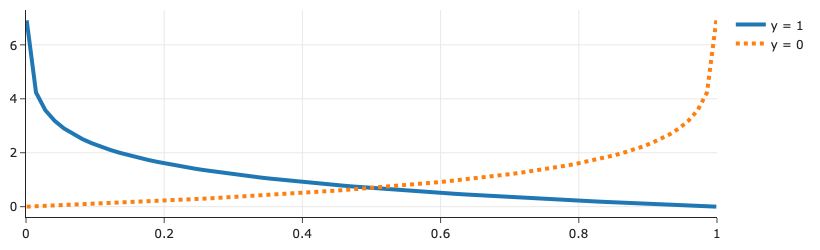

In [21]:
p = np.linspace(0.001,0.999,75)

fig = go.Figure( )

fig.add_trace(go.Scatter(x=p, y = -1*np.log(p), name="y = 1",
                        line=dict(width=4)))
fig.add_trace(go.Scatter(x=p, y = -1*np.log(1-p), name="y = 0",
                        line=dict(width=4, dash='dot')))

fig.update_layout(width=450, height=250, xaxis_range=[0,1])

fig

When $y $ is 1 (solid line), the loss is small for $p$ near 1,
and when $y$ is 0 (dotted line) the loss is small near 0.

If our goal is to fit a constant to the data using logistic loss, then the average loss is:

$$
\begin{aligned}
L(p, \textbf{y}) = &  \frac{1}{n} \sum_i  - y_i  \log(p)  - (1 - y_i) \log (1 -p)) \\
 = & -\frac{n_1}{n} \log(p)  - \frac{n_0}{n} \log (1 -p))
\end{aligned}
$$
Here $n_0$ and $n_1$ are the number of $y_i$ that are 0 and 1, respectively. 
We can differentiate with respect to $ p$ to find the minimizer:


$$
\frac {\partial L(p, \textbf{y})} {\partial p} =  -\frac{n_1}{np}  + \frac{n_0}{n(1-p)}
$$

Then, we set the derivative to 0 and solve for the minimizing value $\hat{p}$:

$$
\begin{aligned}
0 &= -\frac{n_1}{n{\hat{p}}}  + \frac{n_0}{n(1-{\hat{p}})} \\
0 &= - \hat{p}(1-\hat{p}) \frac{n_1}{\hat{p}}  + \hat{p}(1-\hat{p}) \frac{n_0}{(1-{\hat{p}})}\\ 
{n_1} (1-\hat{p})  & = {n_0} \hat{p}\\
\hat{p}  & = \frac{n_1}{n}
\end{aligned}
$$

(The final equation results from noting that $n_0 + n_1 = n$.)

To fit a more complex model based on the logistic function, we can substitute $ \sigma(\theta_0 + \theta_1x) $ for $ p $. And, the loss for the logistic model becomes, 

$$ 
\begin{aligned}
{\ell}(\sigma(\theta_0 + \theta_1x), y) & =  ~ y \ell(\sigma(\theta_0 + \theta_1x), y) + 
(1-y)\ell(\sigma(\theta_0 + \theta_1x), 1-y)   \\
 & = y \log(\sigma(\theta_0 + \theta_1x)) + 
(1-y)\log(\sigma(\theta_0 + \theta_1x))
\end{aligned}
$$

Averaging the loss over the data, we arrive at:

$$
\begin{aligned}
L(\theta_0, \theta_1,\textbf{x}, \textbf{y}) =  \frac{1}{n} \sum_i  & - y_i 
 \log(\sigma(\theta_0 + \theta_1x_i)) \\
 & - (1 - y_i) \log (1 - \sigma(\theta_0 + \theta_1x_i))
\end{aligned}
$$

Unlike with squared loss, there is no closed form solution to this loss function. Instead, we use iterative methods like gradient descent (see {numref}`Chapter %s <ch:optimization>`) to minimize the average loss. This is also one of the reasons we don't use squared error loss for logistic models---the average squared error is non-convex which makes it hard to optimize. 

:::{note} 

Logistic loss is also called, *log loss* and *cross-entropy loss*.
Another name for it is the *negative log-likelihood*. This name refers to the technique of fitting models using the likelihood that a probability distribution produced our data. We do not go any further into the background of these alternative approaches here. 

:::

Fitting the logistic model (with the log loss) is called *logistic regression*. Logistic regression is an example of a generalized linear model, a linear model with a non-linear transformation. 

## Fitting a Logistic Model

We can fit logistic models with `scikit-learn`. The package designers made the API very similar to fitting linear models by least squares (see {numref}`Chapter %s <ch:linear>`).  First, we import the logistic regression module.

In [6]:
from sklearn.linear_model import LogisticRegression

Then we set up the regression problem with outcome `y`, the status of the tree, and covariate `X`, the diameter: 

In [7]:
trees['log_diam'] = np.log(trees['diameter']) 
X = trees[['log_diam']]
y = trees['status_0_1']

Then, we fit the logistic regression and examine the intercept and coefficient for diameter:

In [13]:
lr_model = LogisticRegression()
lr_model.fit(X, y)

[intercept] = lr_model.intercept_
[[coef]] = lr_model.coef_
print(f'Intercept:           {intercept:.1f}')
print(f'Diameter coefficient: {coef:.1f}')

Intercept:           -7.4
Diameter coefficient: 3.0


When making a prediction the `predict` function returns the predicted (most likely class), and  the `predict_proba` returns the predicted probability. For a tree with diameter 6, we expect the prediction to be 0 (meaning `standing`) with a high probability. Let's check:

In [19]:
diameter = 6
[pred_prof] = lr_model.predict_proba([[np.log(diameter)]])
print(f'Predicted probabilities: {pred_prof}')

Predicted probabilities: [0.87 0.13]


Thus, the model predicts that a tree with diameter of 6 has a 0.87 probability for the class `standing` and 0.13 probability for `fallen`.

Now that we've fit a model with one feature, we might want to see if including another feature like the strength of the storm can improve the model. To do this, we can fit a multiple logistic regression by adding a feature to `X` and fitting the model again.

Notice that we fit a logistic regression we fit a model to predict probabilities---the model predicts that a tree with diameter 6 has a 0.87 probability of class `standing` and 0.13 probability of class `fallen`.
Since probabilities can be any number between 0 and 1, we need to convert the probabilities back to categories to perform classification. We'll address this classification problem in the next section.